# Tarea 4



## Caracteristicas

### Limones

1. distancia al centroide de cada punto no varia mucho con respecto a la distancia promedio de todos los pixeles al centroide
2. circular/ovalado
3. diametro 1 circulo hough > x numero definido por el diametro de la arandela, es decir mucho mayor al diametro de la arandela
4. gran cantidad de pixeles

### Arandelas

1. circular
2. centro con pocos pixeles
3. pocos pixeles
4. l y h muy pequeños
5. centroide es de un valor diferente de los pixeles del objeto

### Clavos

1. largos
2. brillantes
3. cabeza larga
4. distancia al centroide de varios puntos varia mucho con respecto a la distancia promedio de todos los pixeles al centroide
5. delgados

### Expander

1. largo, menos largo que un clavo
2. delgado, mas ancho que el clavo
3. puede tener patitas
4. 


### Prensa

1. similar en largo que expander, menos que clavo
2. simitria a lo largo
3. corte transversal una mitad mas ancha que la otra
4. 

## Setup

In [25]:
#Importar las librerías por utilizar
import os
import numpy as np
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import math
from skimage import io
from skimage.transform import resize, probabilistic_hough_line,hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from skimage.color import rgb2gray
from skimage.draw import circle_perimeter
from skimage import exposure
from skimage.morphology import disk
from skimage.morphology import (erosion, dilation, opening, closing)
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops, regionprops_table
from skimage import data, img_as_float
from skimage import exposure
from scipy import ndimage

In [26]:
#Obtener la direccion de las imagenes
path = os.getcwd()

folder = 'MUESTRAS'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_fotos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    foto = io.imread(file_path)
    lista_fotos.append(foto)

In [27]:
#Imagen por procesar
index = 3

## Preprocesado

### Análisis de las Imágenes

Antes de buscar una solución al problema descrito es vital realizar las operaciones de preprocesado que permitan manipular y realizar la clasificación de la mejor manera posible. El primer paso es una evaluación general de las imagenes mediante un histograma y la distribución acumulativa, mediante las funciones np.histogram y skimage.exposure.cumulative_distribution

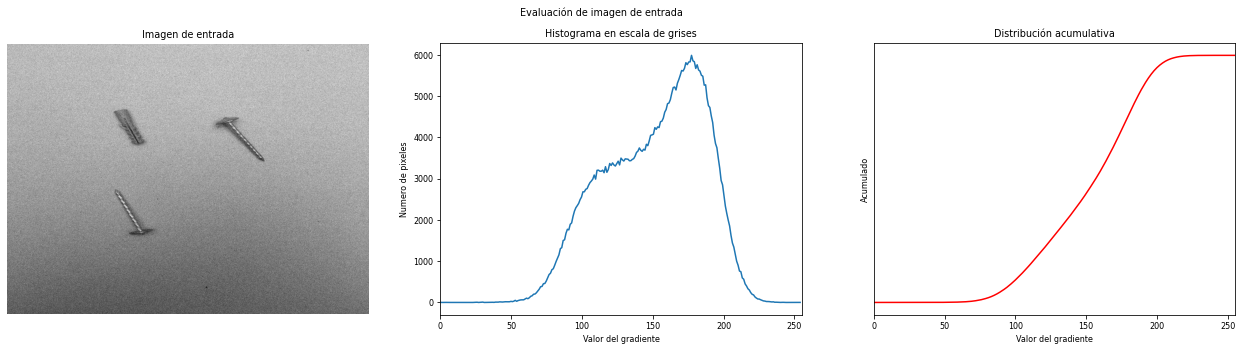

In [28]:
# Evaluación de las imágenes
# https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html
fig_eval, axs = plt.subplots(1,3,figsize=(22,5))
fig_eval.suptitle('Evaluación de imagen de entrada')

axs[0].set_title("Imagen de entrada")
axs[0].imshow(lista_fotos[index],cmap=plt.cm.gray)
axs[0].set_axis_off()

# create the histogram
histogram, bin_edges = np.histogram(lista_fotos[index], bins=256, range=(0, 255))
# Display histogram
axs[1].set_title("Histograma en escala de grises")
axs[1].set_xlabel("Valor del gradiente")
axs[1].set_ylabel("Numero de pixeles")
axs[1].set_xlim([0.0, 255])
axs[1].plot(bin_edges[0:-1], histogram)
# Display cumulative distribution
img_cdf, bins = exposure.cumulative_distribution(lista_fotos[index], 256)
axs[2].set_title("Distribución acumulativa")
axs[2].set_xlabel("Valor del gradiente")
axs[2].set_ylabel("Acumulado")
axs[2].set_xlim([0.0, 255])
axs[2].plot(bins, img_cdf, 'r')
axs[2].set_yticks([])

plt.show()

### Mejora del contraste

Como se puede apreciar en el histograma, la imagen de entrada puede mejorar su contraste, para esto se tienen varias opciones que ofrece scikit-image: stretching, ecualización y ecualización adaptativa. Los resultados se muestran a continuación:

C:\Users\carlo\AppData\Local\Temp\ipykernel_9332\1390524705.py:48: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  axes = np.zeros((2, 4), dtype=np.object)


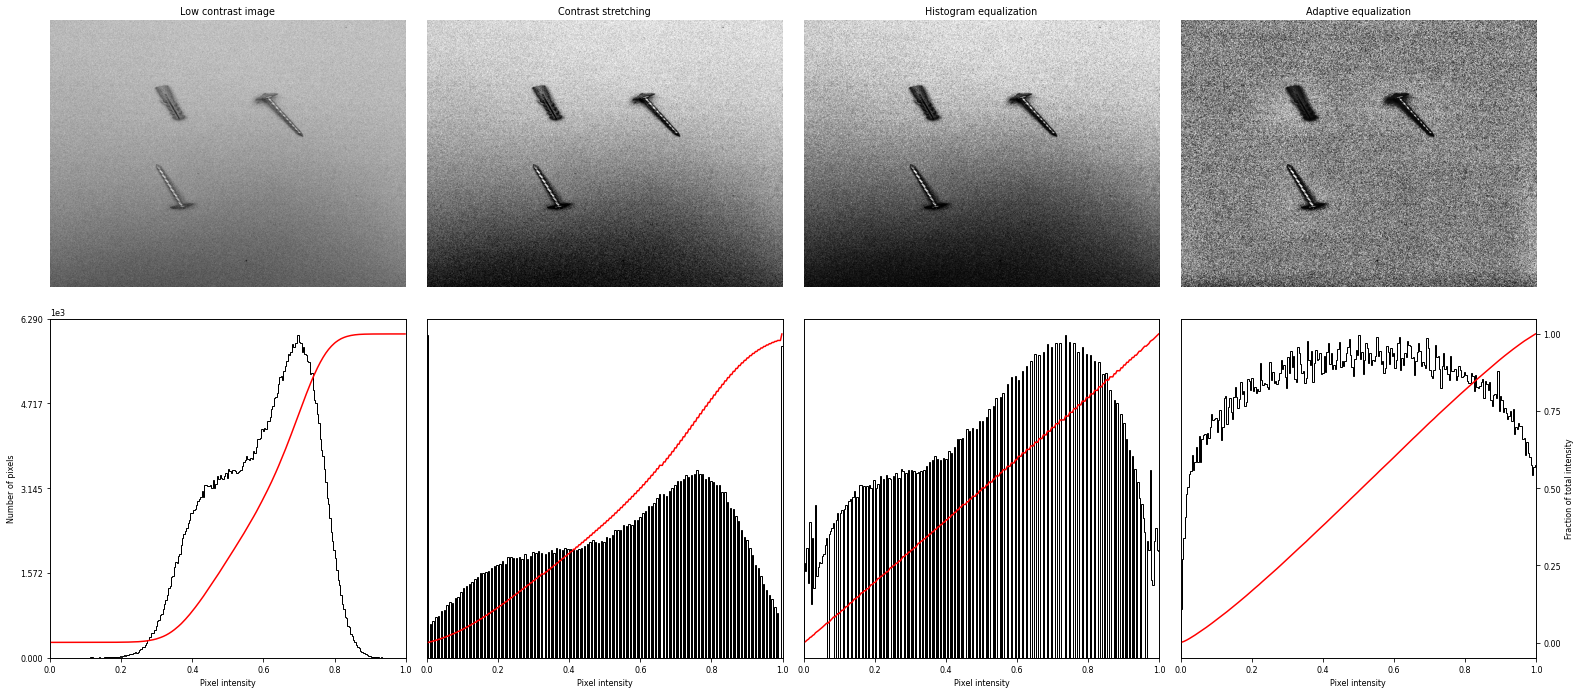

In [29]:
# Mejora del contraste
# https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html
matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
img = lista_fotos[index]

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(22, 10))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

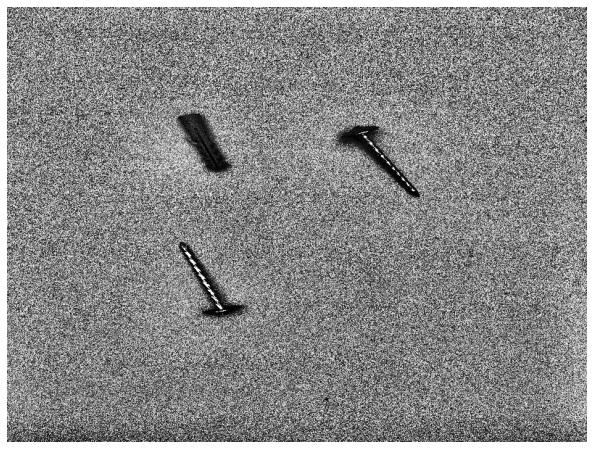

In [30]:
# Ecualizacion adaptativa
EQUA = exposure.equalize_adapthist(lista_fotos[index], clip_limit=0.03)
plt.figure(figsize = (26,8))
plt.imshow(EQUA,cmap='gray')
plt.axis('off')
plt.show()

Con la ecualización adaptativa se reducen las sombras en la parte inferior de la imagen y se obtiene máximo contraste, por lo tanto se escoge esta función para mejorar el contraste. Cabe resaltar que los objetos ahora se ven mucho mejor que la imagen original.

### Filtrado de Ruido y binarización

Ahora lo que sigue es tratar de reducir el ruido lo más posible sin perder detalle de los bordes, para esto se utiliza la función scipy.ndimage.gaussian_filter que permite reducir el ruido de tipo gaussiano, y mediante operaciones aritméticas simples se puede recuperar los bordes. Además se tendrán rellenos más suavizados de forma que a la hora de obtener los objetos (binarización) se reduce la aparición de estos en la imagen. Mediante pruebas con las muestras se determinó que la umbralización de la binarización se debe hacer al 30% (gradiente 76.5)

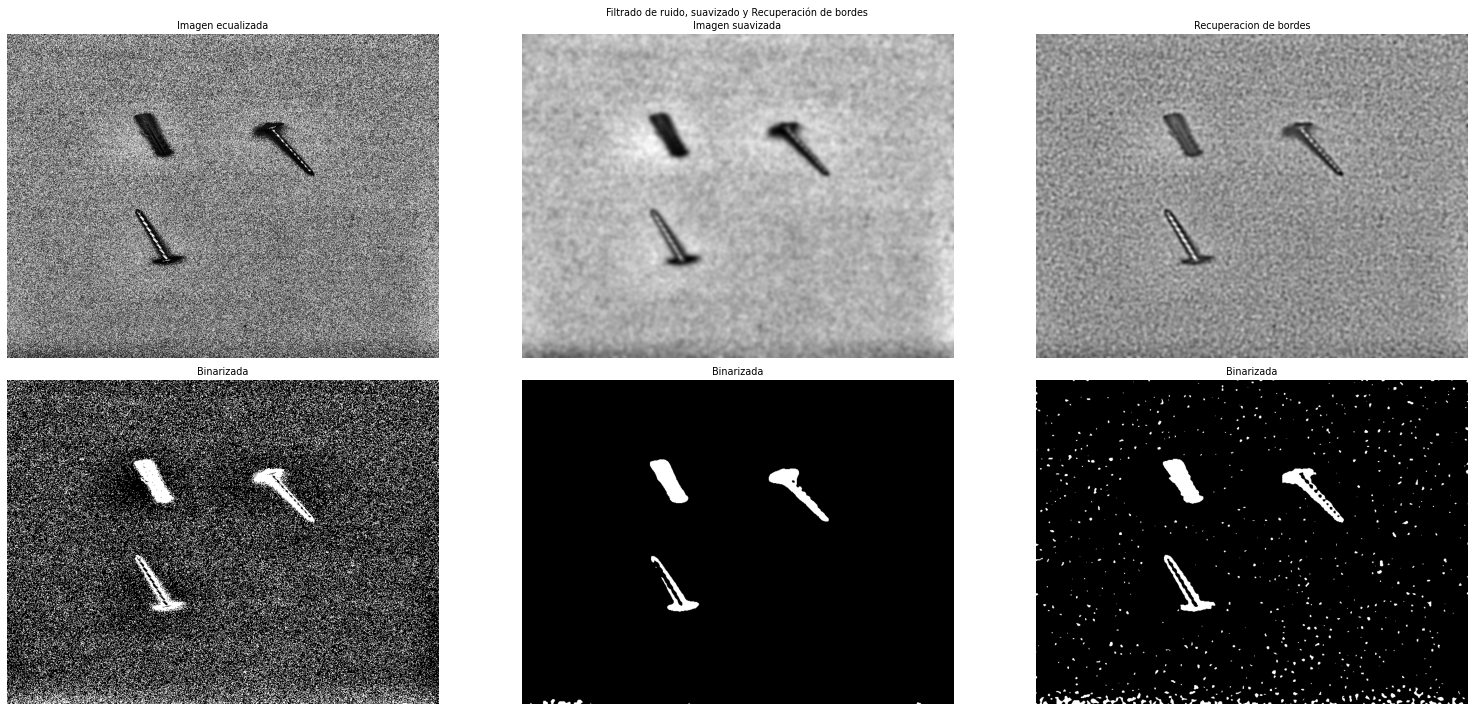

In [31]:
# Filtrado de Ruido
thresh=0.3
sigma = 3

f = EQUA
binary_f = f > thresh
binary_f = ~binary_f

blurred_f = ndimage.gaussian_filter(f, sigma)
binary_blurred_f = blurred_f > thresh
binary_blurred_f = ~binary_blurred_f

filter_blurred_f = ndimage.gaussian_filter(blurred_f, 1)
alpha = 40
sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f)
binary_sharpened = sharpened > thresh
binary_sharpened = ~binary_sharpened

fig1, axs = plt.subplots(2,3,figsize=(22,10))
fig1.suptitle('Filtrado de ruido, suavizado y Recuperación de bordes')

axs[0,0].set_title("Imagen ecualizada")
axs[0,0].imshow(f, cmap=plt.cm.gray)
axs[0,0].set_axis_off()
axs[1,0].set_title("Binarizada")
axs[1,0].imshow(binary_f, cmap=plt.cm.gray)
axs[1,0].set_axis_off()

axs[0,1].set_title("Imagen suavizada")
axs[0,1].imshow(blurred_f, cmap=plt.cm.gray)
axs[0,1].set_axis_off()
axs[1,1].set_title("Binarizada")
axs[1,1].imshow(binary_blurred_f, cmap=plt.cm.gray)
axs[1,1].set_axis_off()

axs[0,2].set_title("Recuperacion de bordes")
axs[0,2].imshow(sharpened, cmap=plt.cm.gray)
axs[0,2].set_axis_off()
axs[1,2].set_title("Binarizada")
axs[1,2].imshow(binary_sharpened, cmap=plt.cm.gray)
axs[1,2].set_axis_off()

plt.tight_layout()
plt.show()

Como se aprecia en la imagen. La imagen ecualizada queda con mucho ruido luego de la binarización. Con el filtro gaussiano, el ruido se elimina, pero los objetos pierden algunas características vitales (principalmente los más pequeños y delgados); Al realizar la recuperación de bordes antes de la binarización, las características de los objetos se mantienen más (punto intermedio entre los dos). Ahora bien, se puede aplicar un filtro de mediana para eleiminar los pequeños puntos restantes del ruido. Posterior a ello, se realiza una operación de clausura, de forma que los objetos más grandes se unan en uno solo en caso de que no lo estén. A pesar de que la imagen borrosa binarizada pierde ciertos detalles, es la que mejor características de ruido presenta, por lo tanto, se utilizará, de ahora en adelante. Posterior al filtrado gaussiano, se puede realizar una clausura para recuperar parte de los detalles:

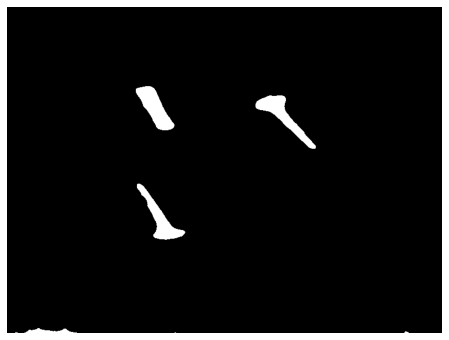

In [32]:
# Clausura de imagen binarizada
footprint = disk(18)
limp = closing(binary_blurred_f,footprint)*255
plt.figure(figsize = (12,6))
plt.imshow(limp,cmap='gray')
#plt.imshow(limp,cmap='gray')
plt.axis('off')
plt.show()

Eliminar ruido de los bordes

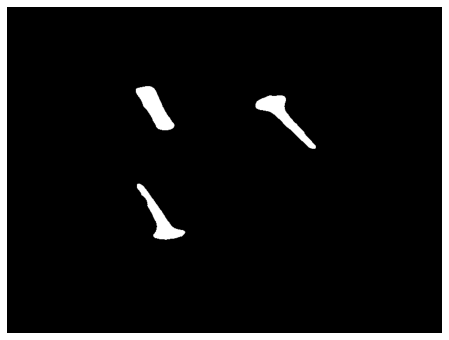

In [33]:
no_borders = clear_border(limp)
plt.figure(figsize = (12,6))
plt.imshow(no_borders, cmap = "gray")
plt.axis('off')
plt.show()

### Función de preprocesado

In [34]:
def prepro(index,lista_fts=lista_fotos):
    EQUA = exposure.equalize_adapthist(lista_fts[index], clip_limit=0.03)
    f = EQUA
    blurred_f = ndimage.gaussian_filter(f, sigma)
    binary_blurred_f = blurred_f > thresh
    binary_blurred_f = ~binary_blurred_f
    footprint = disk(10)
    limp = closing(binary_blurred_f,footprint)*255
    no_borders = clear_border(limp)
    return no_borders

## Segmentación

La segmentación se realiza mediante la función skimage.measure.label que realiza crecimiento de regiones y etiqueta las regiones. La imagen deja de ser binaria, y cada región tiene un gradiente característico para diferenciar.

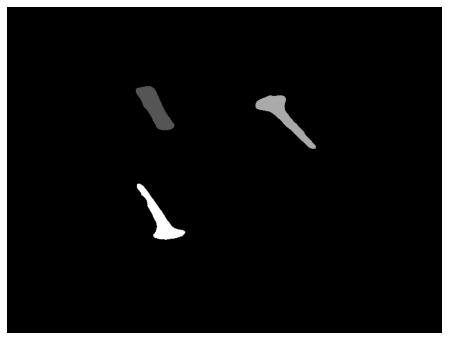

In [35]:
# https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label
segmented, num_segments = label(no_borders,return_num = True,connectivity= None)
plt.figure(figsize = (12,6))
plt.imshow(segmented, cmap='gray')
plt.axis('off')
plt.show()

## Clasificación

Obtener caracteristicas de las regiones con skimage.measure.regionprops

In [36]:
# https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops
props = regionprops(segmented)

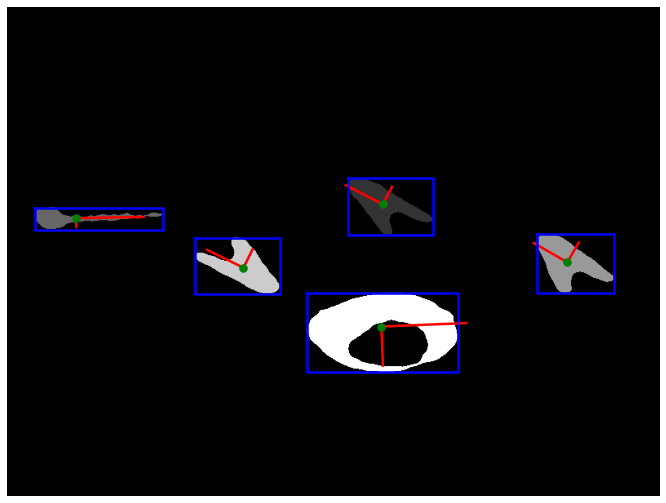

In [37]:
index=9
no_borders = prepro(index)

regions, n_regions = label(no_borders,return_num = True,connectivity= None)

props = regionprops(regions)

fig, ax = plt.subplots(figsize=(15, 9))
ax.imshow(regions, cmap=plt.cm.gray)

for prop in props:
    y0, x0 = prop.centroid
    orientation = prop.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * prop.axis_minor_length
    y1 = y0 - math.sin(orientation) * 0.5 * prop.axis_minor_length
    x2 = x0 - math.sin(orientation) * 0.5 * prop.axis_major_length
    y2 = y0 - math.cos(orientation) * 0.5 * prop.axis_major_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = prop.bbox
    #bbox = min_y min_x max_y max_x
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)

ax.axis("off")
plt.show()

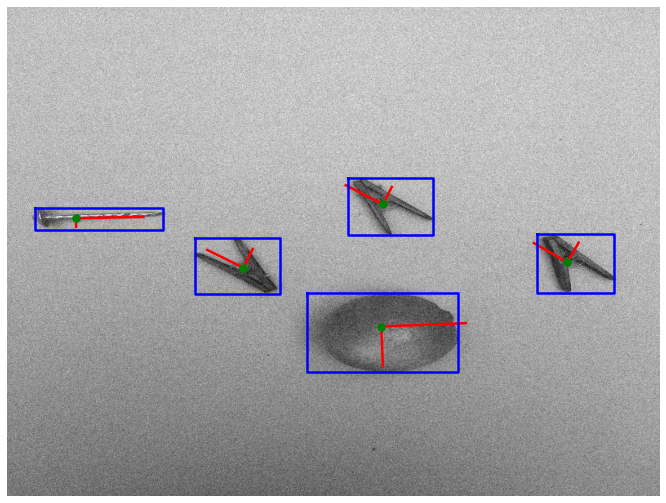

In [38]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.imshow(lista_fotos[index], cmap=plt.cm.gray)

for prop in props:
    y0, x0 = prop.centroid
    orientation = prop.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * prop.axis_minor_length
    y1 = y0 - math.sin(orientation) * 0.5 * prop.axis_minor_length
    x2 = x0 - math.sin(orientation) * 0.5 * prop.axis_major_length
    y2 = y0 - math.cos(orientation) * 0.5 * prop.axis_major_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = prop.bbox
    #bbox = min_y min_x max_y max_x
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)

ax.axis("off")
plt.show()

## CARACTERISTICAS

### Característica 1: Área
Diferencia clavos

In [39]:
# Hacer una lista de Imagenes de clavos
folder = 'CLAVOS'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_clavos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    clavo = io.imread(file_path)
    lista_clavos.append(clavo)
areas_clavos = []
for index in range(len(lista_clavos)):
    nb = prepro(index,lista_clavos)
    regs, nregs = label(nb,return_num = True,connectivity= None)
    props = regionprops(regs)
    for prop in props:
        if prop.area > 800:
            areas_clavos.append(prop.area)
print('area minima: ' + str(np.min(areas_clavos)))
print('area maxima: ' + str(np.max(areas_clavos)))
print('cantidad: ' + str(len(areas_clavos)))

area minima: 929
area maxima: 2078
cantidad: 38


In [40]:
# Hacer una lista de Imagenes de arandelas
folder = 'ARANDELAS'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_clavos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    clavo = io.imread(file_path)
    lista_clavos.append(clavo)
areas_clavos = []
for index in range(len(lista_clavos)):
    nb = prepro(index,lista_clavos)
    regs, nregs = label(nb,return_num = True,connectivity= None)
    props = regionprops(regs)
    for prop in props:
        if prop.area > 800:
            areas_clavos.append(prop.area)
print('area minima: ' + str(np.min(areas_clavos)))
print('area maxima: ' + str(np.max(areas_clavos)))
print('cantidad: ' + str(len(areas_clavos)))

area minima: 2218
area maxima: 4784
cantidad: 42


In [41]:
# Hacer una lista de Imagenes de prensas
folder = 'PRENSAS'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_clavos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    clavo = io.imread(file_path)
    lista_clavos.append(clavo)
areas_clavos = []
for index in range(len(lista_clavos)):
    nb = prepro(index,lista_clavos)
    regs, nregs = label(nb,return_num = True,connectivity= None)
    props = regionprops(regs)
    for prop in props:
        if prop.area > 800:
            areas_clavos.append(prop.area)
print('area minima: ' + str(np.min(areas_clavos)))
print('area maxima: ' + str(np.max(areas_clavos)))
print('cantidad: ' + str(len(areas_clavos)))

area minima: 3004
area maxima: 7995
cantidad: 40


In [42]:
# Hacer una lista de Imagenes de espander
folder = 'ESPANDER'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_clavos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    clavo = io.imread(file_path)
    lista_clavos.append(clavo)
areas_clavos = []
for index in range(len(lista_clavos)):
    nb = prepro(index,lista_clavos)
    regs, nregs = label(nb,return_num = True,connectivity= None)
    props = regionprops(regs)
    for prop in props:
        if prop.area > 800:
            areas_clavos.append(prop.area)
print('area minima: ' + str(np.min(areas_clavos)))
print('area maxima: ' + str(np.max(areas_clavos)))
print('cantidad: ' + str(len(areas_clavos)))

area minima: 2635
area maxima: 4431
cantidad: 37


In [43]:
# Hacer una lista de Imagenes de limones
folder = 'LIMONES'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_clavos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    clavo = io.imread(file_path)
    lista_clavos.append(clavo)
areas_clavos = []
for index in range(len(lista_clavos)):
    nb = prepro(index,lista_clavos)
    regs, nregs = label(nb,return_num = True,connectivity= None)
    props = regionprops(regs)
    for prop in props:
        if prop.area > 800:
            areas_clavos.append(prop.area)
print('area minima: ' + str(np.min(areas_clavos)))
print('area maxima: ' + str(np.max(areas_clavos)))
print('cantidad: ' + str(len(areas_clavos)))

area minima: 7720
area maxima: 12275
cantidad: 37


### Característica 2: Hipotenusa

In [44]:
# Hacer una lista de Imagenes de clavos
folder = 'CLAVOS'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_clavos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    clavo = io.imread(file_path)
    lista_clavos.append(clavo)
hipos_clavos = []
for index in range(len(lista_clavos)):
    nb = prepro(index,lista_clavos)
    regs, nregs = label(nb,return_num = True,connectivity= None)
    props = regionprops(regs)
    for prop in props:
        if prop.area > 800:
            #bbox = min_y min_x max_y max_x
            minr, minc, maxr, maxc = prop.bbox
            deltax = maxc - minc
            deltay = maxr - minr
            hip = np.sqrt(deltax**2 + deltay**2)
            hipos_clavos.append(hip)
print('hipotenusa minima: ' + str(np.min(hipos_clavos)))
print('hipotenusa maxima: ' + str(np.max(hipos_clavos)))
print('cantidad: ' + str(len(hipos_clavos)))

hipotenusa minima: 66.2117814289874
hipotenusa maxima: 162.3884232326923
cantidad: 38


In [45]:
# Hacer una lista de Imagenes de arandelas
folder = 'ARANDELAS'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_clavos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    clavo = io.imread(file_path)
    lista_clavos.append(clavo)
hipos_clavos = []
for index in range(len(lista_clavos)):
    nb = prepro(index,lista_clavos)
    regs, nregs = label(nb,return_num = True,connectivity= None)
    props = regionprops(regs)
    for prop in props:
        if prop.area > 800:
            #bbox = min_y min_x max_y max_x
            minr, minc, maxr, maxc = prop.bbox
            deltax = maxc - minc
            deltay = maxr - minr
            hip = np.sqrt(deltax**2 + deltay**2)
            hipos_clavos.append(hip)
print('hipotenusa minima: ' + str(np.min(hipos_clavos)))
print('hipotenusa maxima: ' + str(np.max(hipos_clavos)))
print('cantidad: ' + str(len(hipos_clavos)))

hipotenusa minima: 80.62257748298549
hipotenusa maxima: 119.95415791042844
cantidad: 42


In [46]:
# Hacer una lista de Imagenes de prensas
folder = 'PRENSAS'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_clavos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    clavo = io.imread(file_path)
    lista_clavos.append(clavo)
hipos_clavos = []
for index in range(len(lista_clavos)):
    nb = prepro(index,lista_clavos)
    regs, nregs = label(nb,return_num = True,connectivity= None)
    props = regionprops(regs)
    for prop in props:
        if prop.area > 800:
            #bbox = min_y min_x max_y max_x
            minr, minc, maxr, maxc = prop.bbox
            deltax = maxc - minc
            deltay = maxr - minr
            hip = np.sqrt(deltax**2 + deltay**2)
            hipos_clavos.append(hip)
print('hipotenusa minima: ' + str(np.min(hipos_clavos)))
print('hipotenusa maxima: ' + str(np.max(hipos_clavos)))
print('cantidad: ' + str(len(hipos_clavos)))

hipotenusa minima: 127.6401190848708
hipotenusa maxima: 240.30397416605493
cantidad: 40


In [47]:
# Hacer una lista de Imagenes de espander
folder = 'ESPANDER'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_clavos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    clavo = io.imread(file_path)
    lista_clavos.append(clavo)
hipos_clavos = []
for index in range(len(lista_clavos)):
    nb = prepro(index,lista_clavos)
    regs, nregs = label(nb,return_num = True,connectivity= None)
    props = regionprops(regs)
    for prop in props:
        if prop.area > 800:
            #bbox = min_y min_x max_y max_x
            minr, minc, maxr, maxc = prop.bbox
            deltax = maxc - minc
            deltay = maxr - minr
            hip = np.sqrt(deltax**2 + deltay**2)
            hipos_clavos.append(hip)
print('hipotenusa minima: ' + str(np.min(hipos_clavos)))
print('hipotenusa maxima: ' + str(np.max(hipos_clavos)))
print('cantidad: ' + str(len(hipos_clavos)))

hipotenusa minima: 90.80198235721508
hipotenusa maxima: 162.50538452617502
cantidad: 37


In [48]:
# Hacer una lista de Imagenes de limones
folder = 'LIMONES'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_clavos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    clavo = io.imread(file_path)
    lista_clavos.append(clavo)
hipos_clavos = []
for index in range(len(lista_clavos)):
    nb = prepro(index,lista_clavos)
    regs, nregs = label(nb,return_num = True,connectivity= None)
    props = regionprops(regs)
    for prop in props:
        if prop.area > 800:
            #bbox = min_y min_x max_y max_x
            minr, minc, maxr, maxc = prop.bbox
            deltax = maxc - minc
            deltay = maxr - minr
            hip = np.sqrt(deltax**2 + deltay**2)
            hipos_clavos.append(hip)
print('hipotenusa minima: ' + str(np.min(hipos_clavos)))
print('hipotenusa maxima: ' + str(np.max(hipos_clavos)))
print('cantidad: ' + str(len(hipos_clavos)))

hipotenusa minima: 170.41420128616042
hipotenusa maxima: 208.00961516237658
cantidad: 37


### Característica 3: l/h que tan circular es, relacion alto entre ancho
DIFERENCIA ARANDELAS Y ESPANDER

In [49]:
# Hacer una lista de Imagenes de clavos
folder = 'CLAVOS'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_clavos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    clavo = io.imread(file_path)
    lista_clavos.append(clavo)
ar_clavos = []
for index in range(len(lista_clavos)):
    nb = prepro(index,lista_clavos)
    regs, nregs = label(nb,return_num = True,connectivity= None)
    props = regionprops(regs)
    for prop in props:
        if prop.area > 800:
            aspect_ratio = prop.axis_major_length/prop.axis_minor_length
            ar_clavos.append(aspect_ratio)
print('l/h minima: ' + str(np.min(ar_clavos)))
print('l/h maxima: ' + str(np.max(ar_clavos)))
print('cantidad: ' + str(len(ar_clavos)))

KeyboardInterrupt: 

In [ ]:
# Hacer una lista de Imagenes de ARANDELAS
folder = 'ARANDELAS'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_clavos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    clavo = io.imread(file_path)
    lista_clavos.append(clavo)
ar_clavos = []
for index in range(len(lista_clavos)):
    nb = prepro(index,lista_clavos)
    regs, nregs = label(nb,return_num = True,connectivity= None)
    props = regionprops(regs)
    for prop in props:
        if prop.area > 800:
            h = 2*prop.axis_minor_length
            l = 2*prop.axis_major_length
            #aspect_ratio = l/h
            aspect_ratio = prop.axis_major_length/prop.axis_minor_length
            ar_clavos.append(aspect_ratio)
print('l/h minima: ' + str(np.min(ar_clavos)))
print('l/h maxima: ' + str(np.max(ar_clavos)))
print('cantidad: ' + str(len(ar_clavos)))

In [ ]:
# Hacer una lista de Imagenes de PRENSAS
folder = 'PRENSAS'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_clavos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    clavo = io.imread(file_path)
    lista_clavos.append(clavo)
ar_clavos = []
for index in range(len(lista_clavos)):
    nb = prepro(index,lista_clavos)
    regs, nregs = label(nb,return_num = True,connectivity= None)
    props = regionprops(regs)
    for prop in props:
        if prop.area > 800:
            aspect_ratio = prop.axis_major_length/prop.axis_minor_length
            ar_clavos.append(aspect_ratio)
print('l/h minima: ' + str(np.min(ar_clavos)))
print('l/h maxima: ' + str(np.max(ar_clavos)))
print('cantidad: ' + str(len(ar_clavos)))

In [ ]:
# Hacer una lista de Imagenes de ESPANDER
folder = 'ESPANDER'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_clavos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    clavo = io.imread(file_path)
    lista_clavos.append(clavo)
ar_clavos = []
for index in range(len(lista_clavos)):
    nb = prepro(index,lista_clavos)
    regs, nregs = label(nb,return_num = True,connectivity= None)
    props = regionprops(regs)
    for prop in props:
        if prop.area > 800:
            aspect_ratio = prop.axis_major_length/prop.axis_minor_length
            ar_clavos.append(aspect_ratio)
print('l/h minima: ' + str(np.min(ar_clavos)))
print('l/h maxima: ' + str(np.max(ar_clavos)))
print('cantidad: ' + str(len(ar_clavos)))

In [ ]:
# Hacer una lista de Imagenes de LIMONES
folder = 'LIMONES'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_clavos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    clavo = io.imread(file_path)
    lista_clavos.append(clavo)
ar_clavos = []
for index in range(len(lista_clavos)):
    nb = prepro(index,lista_clavos)
    regs, nregs = label(nb,return_num = True,connectivity= None)
    props = regionprops(regs)
    for prop in props:
        if prop.area > 800:
            aspect_ratio = prop.axis_major_length/prop.axis_minor_length
            ar_clavos.append(aspect_ratio)
print('l/h minima: ' + str(np.min(ar_clavos)))
print('l/h maxima: ' + str(np.max(ar_clavos)))
print('cantidad: ' + str(len(ar_clavos)))

### Característica 4: menor dimension

In [ ]:
# Hacer una lista de Imagenes de PRENSAS
folder = 'PRENSAS'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_clavos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    clavo = io.imread(file_path)
    lista_clavos.append(clavo)
mind_clavos = []
for index in range(len(lista_clavos)):
    nb = prepro(index,lista_clavos)
    regs, nregs = label(nb,return_num = True,connectivity= None)
    props = regionprops(regs)
    for prop in props:
        if prop.area > 800:
            mind_clavos.append(prop.axis_minor_length)
print('dimension menor minima: ' + str(np.min(mind_clavos)))
print('dimension menor maxima: ' + str(np.max(mind_clavos)))

In [ ]:
# Hacer una lista de Imagenes de ESPANDER
folder = 'ESPANDER'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_clavos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    clavo = io.imread(file_path)
    lista_clavos.append(clavo)
mind_clavos = []
for index in range(len(lista_clavos)):
    nb = prepro(index,lista_clavos)
    regs, nregs = label(nb,return_num = True,connectivity= None)
    props = regionprops(regs)
    for prop in props:
        if prop.area > 800:
            mind_clavos.append(prop.axis_minor_length)
print('dimension menor minima: ' + str(np.min(mind_clavos)))
print('dimension menor maxima: ' + str(np.max(mind_clavos)))

In [ ]:
# Hacer una lista de Imagenes de LIMONES
folder = 'LIMONES'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_clavos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    clavo = io.imread(file_path)
    lista_clavos.append(clavo)
mind_clavos = []
for index in range(len(lista_clavos)):
    nb = prepro(index,lista_clavos)
    regs, nregs = label(nb,return_num = True,connectivity= None)
    props = regionprops(regs)
    for prop in props:
        if prop.area > 800:
            mind_clavos.append(prop.axis_minor_length)
print('dimension menor minima: ' + str(np.min(mind_clavos)))
print('dimension menor maxima: ' + str(np.max(mind_clavos)))

### Característica 5: mayor dimension

In [ ]:
# Hacer una lista de Imagenes de PRENSAS
folder = 'PRENSAS'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_clavos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    clavo = io.imread(file_path)
    lista_clavos.append(clavo)
maxd_clavos = []
for index in range(len(lista_clavos)):
    nb = prepro(index,lista_clavos)
    regs, nregs = label(nb,return_num = True,connectivity= None)
    props = regionprops(regs)
    for prop in props:
        if prop.area > 800:
            maxd_clavos.append(prop.axis_major_length)
print('dimension mayor minima: ' + str(np.min(maxd_clavos)))
print('dimension mayor maxima: ' + str(np.max(maxd_clavos)))

In [ ]:
# Hacer una lista de Imagenes de LIMONES
folder = 'LIMONES'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_clavos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    clavo = io.imread(file_path)
    lista_clavos.append(clavo)
maxd_clavos = []
for index in range(len(lista_clavos)):
    nb = prepro(index,lista_clavos)
    regs, nregs = label(nb,return_num = True,connectivity= None)
    props = regionprops(regs)
    for prop in props:
        if prop.area > 800:
            maxd_clavos.append(prop.axis_major_length)
print('dimension mayor minima: ' + str(np.min(maxd_clavos)))
print('dimension mayor maxima: ' + str(np.max(maxd_clavos)))

### Característica 6: area con agujeros rellenos
Diferencia prensas de limones, identifica clavos y mismos resultados que area pero permite diferenciar prensas de limones

In [ ]:
# Hacer una lista de Imagenes de CLAVOS
folder = 'CLAVOS'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_clavos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    clavo = io.imread(file_path)
    lista_clavos.append(clavo)
maxd_clavos = []
for index in range(len(lista_clavos)):
    nb = prepro(index,lista_clavos)
    regs, nregs = label(nb,return_num = True,connectivity= None)
    props = regionprops(regs)
    for prop in props:
        if prop.area > 800:
            maxd_clavos.append(prop.area_filled)
print('area sin agujeros minima: ' + str(np.min(maxd_clavos)))
print('area sin agujeros maxima: ' + str(np.max(maxd_clavos)))

In [ ]:
# Hacer una lista de Imagenes de ARANDELAS
folder = 'ARANDELAS'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_clavos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    clavo = io.imread(file_path)
    lista_clavos.append(clavo)
maxd_clavos = []
for index in range(len(lista_clavos)):
    nb = prepro(index,lista_clavos)
    regs, nregs = label(nb,return_num = True,connectivity= None)
    props = regionprops(regs)
    for prop in props:
        if prop.area > 800:
            maxd_clavos.append(prop.area_filled)
print('area sin agujeros minima: ' + str(np.min(maxd_clavos)))
print('area sin agujeros maxima: ' + str(np.max(maxd_clavos)))

In [ ]:
# Hacer una lista de Imagenes de PRENSAS
folder = 'PRENSAS'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_clavos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    clavo = io.imread(file_path)
    lista_clavos.append(clavo)
maxd_clavos = []
for index in range(len(lista_clavos)):
    nb = prepro(index,lista_clavos)
    regs, nregs = label(nb,return_num = True,connectivity= None)
    props = regionprops(regs)
    for prop in props:
        if prop.area > 800:
            maxd_clavos.append(prop.area_filled)
print('area sin agujeros minima: ' + str(np.min(maxd_clavos)))
print('area sin agujeros maxima: ' + str(np.max(maxd_clavos)))

In [ ]:
# Hacer una lista de Imagenes de ESPANDER
folder = 'ESPANDER'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_clavos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    clavo = io.imread(file_path)
    lista_clavos.append(clavo)
maxd_clavos = []
for index in range(len(lista_clavos)):
    nb = prepro(index,lista_clavos)
    regs, nregs = label(nb,return_num = True,connectivity= None)
    props = regionprops(regs)
    for prop in props:
        if prop.area > 800:
            maxd_clavos.append(prop.area_filled)
print('area sin agujeros minima: ' + str(np.min(maxd_clavos)))
print('area sin agujeros maxima: ' + str(np.max(maxd_clavos)))

In [ ]:
# Hacer una lista de Imagenes de LIMONES
folder = 'LIMONES'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_clavos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    clavo = io.imread(file_path)
    lista_clavos.append(clavo)
maxd_clavos = []
for index in range(len(lista_clavos)):
    nb = prepro(index,lista_clavos)
    regs, nregs = label(nb,return_num = True,connectivity= None)
    props = regionprops(regs)
    for prop in props:
        if prop.area > 800:
            maxd_clavos.append(prop.area_filled)
print('area sin agujeros minima: ' + str(np.min(maxd_clavos)))
print('area sin agujeros maxima: ' + str(np.max(maxd_clavos)))

### Característica 7: area de rectangulo orientado vs area objeto, para limones no sirve porque tiene un agujero
Diferencia prensas de espander

In [ ]:
# Hacer una lista de Imagenes de CLAVOS
folder = 'CLAVOS'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_clavos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    clavo = io.imread(file_path)
    lista_clavos.append(clavo)
rr_clavos = []
for index in range(len(lista_clavos)):
    nb = prepro(index,lista_clavos)
    regs, nregs = label(nb,return_num = True,connectivity= None)
    props = regionprops(regs)
    for prop in props:
        if prop.area > 800:
            h = prop.axis_minor_length
            l = prop.axis_major_length
            rect_ratio = prop.area/(h*l)
            rr_clavos.append(rect_ratio)
print('l/h minima: ' + str(np.min(rr_clavos)))
print('l/h maxima: ' + str(np.max(rr_clavos)))
print('cantidad: ' + str(len(rr_clavos)))

In [ ]:
# Hacer una lista de Imagenes de ARANDELAS
folder = 'ARANDELAS'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_clavos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    clavo = io.imread(file_path)
    lista_clavos.append(clavo)
rr_clavos = []
for index in range(len(lista_clavos)):
    nb = prepro(index,lista_clavos)
    regs, nregs = label(nb,return_num = True,connectivity= None)
    props = regionprops(regs)
    for prop in props:
        if prop.area > 800:
            h = prop.axis_minor_length
            l = prop.axis_major_length
            rect_ratio = prop.area/(h*l)
            rr_clavos.append(rect_ratio)
print('l/h minima: ' + str(np.min(rr_clavos)))
print('l/h maxima: ' + str(np.max(rr_clavos)))
print('cantidad: ' + str(len(rr_clavos)))

In [ ]:
# Hacer una lista de Imagenes de PRENSAS
folder = 'PRENSAS'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_clavos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    clavo = io.imread(file_path)
    lista_clavos.append(clavo)
rr_clavos = []
for index in range(len(lista_clavos)):
    nb = prepro(index,lista_clavos)
    regs, nregs = label(nb,return_num = True,connectivity= None)
    props = regionprops(regs)
    for prop in props:
        if prop.area > 800:
            h = prop.axis_minor_length
            l = prop.axis_major_length
            rect_ratio = prop.area/(h*l)
            rr_clavos.append(rect_ratio)
print('l/h minima: ' + str(np.min(rr_clavos)))
print('l/h maxima: ' + str(np.max(rr_clavos)))
print('cantidad: ' + str(len(rr_clavos)))

In [ ]:
# Hacer una lista de Imagenes de ESPANDER
folder = 'ESPANDER'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_clavos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    clavo = io.imread(file_path)
    lista_clavos.append(clavo)
rr_clavos = []
for index in range(len(lista_clavos)):
    nb = prepro(index,lista_clavos)
    regs, nregs = label(nb,return_num = True,connectivity= None)
    props = regionprops(regs)
    for prop in props:
        if prop.area > 800:
            h = prop.axis_minor_length
            l = prop.axis_major_length
            rect_ratio = prop.area/(h*l)
            rr_clavos.append(rect_ratio)
print('l/h minima: ' + str(np.min(rr_clavos)))
print('l/h maxima: ' + str(np.max(rr_clavos)))
print('cantidad: ' + str(len(rr_clavos)))

In [ ]:
# Hacer una lista de Imagenes de LIMONES
folder = 'LIMONES'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_clavos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    clavo = io.imread(file_path)
    lista_clavos.append(clavo)
rr_clavos = []
for index in range(len(lista_clavos)):
    nb = prepro(index,lista_clavos)
    regs, nregs = label(nb,return_num = True,connectivity= None)
    props = regionprops(regs)
    for prop in props:
        if prop.area > 800:
            h = prop.axis_minor_length
            l = prop.axis_major_length
            rect_ratio = prop.area/(h*l)
            rr_clavos.append(rect_ratio)
print('l/h minima: ' + str(np.min(rr_clavos)))
print('l/h maxima: ' + str(np.max(rr_clavos)))
print('cantidad: ' + str(len(rr_clavos)))

## Clasificacion implementacion

In [ ]:
def clasificacion_debug(regions):
    clavos = 0
    arandelas = 0
    espanders = 0
    prensas = 0
    limones = 0
    error = 0
    props = regionprops(regions)
    for prop in props:
        if prop.area > 700:
            h = prop.axis_minor_length
            l = prop.axis_major_length
            area_ratio = prop.area/(h*l)
            aspect_ratio = l/h
            area = prop.area_filled
            #identifica clavos
            if (area >= 800 and area < 2150) and (aspect_ratio >= 1.1 and aspect_ratio < 3.25) and (rect_ratio >= 0.9 and area_ratio < 1.2):
                clavos +=1
                print(f"encontre un clavo en: {prop.centroid}, de area: {area}, ap ratio {aspect_ratio} y area ratio {area_ratio}")
            #identifica arandelas
            elif (area >= 2150 and area < 4900) and (aspect_ratio >= 1.1 and aspect_ratio < 3.25) and (rect_ratio >= 0.9 and area_ratio < 1.2):
                arandelas +=1
                print(f"encontre un arandela en: {prop.centroid}, de area: {area}, ap ratio {aspect_ratio} y area ratio {area_ratio}")
            #identifica prensas
            elif (area >= 2850 and area < 8050) and (aspect_ratio >= 1.1 and aspect_ratio < 3.25) and (rect_ratio >= 0.9 and area_ratio < 1.2):
                prensas +=1
                print(f"encontre un prensa en: {prop.centroid}, de area: {area}, ap ratio {aspect_ratio} y area ratio {area_ratio}")
            #identifica espanders
            elif (area >= 2500 and area < 4350) and (aspect_ratio >= 1.1 and aspect_ratio < 3.25) and (rect_ratio >= 0.9 and area_ratio < 1.2):
                espanders +=1
                print(f"encontre un espander en: {prop.centroid}, de area: {area}, ap ratio {aspect_ratio} y area ratio {area_ratio}")
            #identifica limones
            elif (area >= 8200) and (aspect_ratio >= 1.1 and aspect_ratio < 3.25) and (rect_ratio >= 0.9 and area_ratio < 1.2):
                limones +=1
                print(f"encontre un limon en: {prop.centroid}, de area: {area}, ap ratio {aspect_ratio} y area ratio {area_ratio}")
            else:
                error +=1
                print(f"encontre un error en: {prop.centroid}, de area: {area}, ap ratio {aspect_ratio} y area ratio {area_ratio}")
    return clavos, arandelas, prensas, espanders, limones, error

Fallo en la 93 hay contacto entre dos clavos y los detecta como prensa debido a la forma si se juntan ambas siluetas

In [ ]:
def clasificacion(regions):
    clavos = 0
    arandelas = 0
    espanders = 0
    prensas = 0
    limones = 0
    error = 0
    props = regionprops(regions)
    for prop in props:
        if prop.area > 700:
            h = prop.axis_minor_length
            l = prop.axis_major_length
            area_ratio = prop.area/(h*l)
            aspect_ratio = l/h
            area = prop.area_filled
            #identifica limones
            if (area >= 8000):
                limones +=1
                #print(f"encontre un limon")
            #identifica clavos
            elif (area >= 1200 and area < 3100) and (aspect_ratio >= 2.52 and aspect_ratio < 11) and (area_ratio >= 0.35 and area_ratio < 0.56):
                clavos +=1
                #print(f"encontre un clavo")
            #identifica arandelas
            elif (area >= 800 and area < 2000) and (aspect_ratio >= 1.5 and aspect_ratio < 1.95) and (area_ratio >= 0.77 and area_ratio < 0.79):
                arandelas +=1
                #print(f"encontre un arandela")
            #identifica prensas
            elif (area >= 2500 and area < 5200) and (aspect_ratio >= 1.35 and aspect_ratio < 3.39) and (area_ratio >= 0.5 and area_ratio < 0.66):
                prensas +=1
                #print(f"encontre un prensa")
            #identifica espanders
            elif (area >= 1400 and area < 3700) and (aspect_ratio >= 2.1 and aspect_ratio < 7.1) and (area_ratio >= 0.73 and area_ratio < 0.77):
                espanders +=1
                #print(f"encontre un espander")            
            else:
                error +=1
                print(f"encontre un error en: {prop.centroid}, de area: {area}, ap ratio {aspect_ratio} y area ratio {area_ratio}")
    return clavos, arandelas, prensas, espanders, limones, error

In [ ]:
for index in range(len(lista_fotos)):
    no_borders = prepro(index,lista_fotos)
    props = regionprops(regions)
    regions, n_regions = label(no_borders,return_num = True,connectivity= None)
    resultados = clasificacion(regions)
    print(f"clavos: {resultados[0]}, arandelas: {resultados[1]}, prensas: {resultados[2]}, espanders: {resultados[3]}, limones: {resultados[4]}, sin identificar:  {resultados[5]}")
print(files)

## Recopilacion de funciones y ultimos detales para .py

In [50]:
def prepro(img):
    EQUA = exposure.equalize_adapthist(img, clip_limit=0.03)
    f = EQUA
    blurred_f = ndimage.gaussian_filter(f, sigma)
    binary_blurred_f = blurred_f > thresh
    binary_blurred_f = ~binary_blurred_f
    footprint = disk(10)
    limp = closing(binary_blurred_f,footprint)*255
    no_borders = clear_border(limp)
    return no_borders

In [51]:
def clasificacion(regions):
    clavos = 0
    arandelas = 0
    espanders = 0
    prensas = 0
    limones = 0
    error = 0
    props = regionprops(regions)
    for prop in props:
        if prop.area > 700:
            h = prop.axis_minor_length
            l = prop.axis_major_length
            area_ratio = prop.area/(h*l)
            aspect_ratio = l/h
            area = prop.area_filled
            #identifica limones
            if (area >= 8000):
                limones +=1
            #identifica clavos
            elif (area >= 1200 and area < 3100) and (aspect_ratio >= 2.52 and aspect_ratio < 11) and (area_ratio >= 0.35 and area_ratio < 0.56):
                clavos +=1
            #identifica arandelas
            elif (area >= 800 and area < 2000) and (aspect_ratio >= 1.5 and aspect_ratio < 1.95) and (area_ratio >= 0.77 and area_ratio < 0.79):
                arandelas +=1
            #identifica prensas
            elif (area >= 2500 and area < 5200) and (aspect_ratio >= 1.35 and aspect_ratio < 3.39) and (area_ratio >= 0.5 and area_ratio < 0.66):
                prensas +=1
            #identifica espanders
            elif (area >= 1400 and area < 3700) and (aspect_ratio >= 2.1 and aspect_ratio < 7.1) and (area_ratio >= 0.73 and area_ratio < 0.77):
                espanders +=1
            else:
                error +=1
    return clavos, arandelas, prensas, espanders, limones, error

In [57]:
#if os.path.exists("report_file.txt"):
    #os.remove("report_file.txt")
#report_file = open("report_file.txt", "x")
path = os.getcwd()
folder = 'MUESTRAS'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
for file in files:
    file_path = os.path.join(folder_path, file)
    foto = io.imread(file_path)
    prepro_img = prepro(foto)
    regions, n_regions = label(prepro_img,return_num = True,connectivity= None)
    file_res = clasificacion(regions)
    res_report =file + str(file_res) + '\n'
    #report_file.write(res_report)
    print(res_report)
#report_file.close()

CLASS-107.png(0, 2, 2, 0, 0, 0)

CLASS-118.png(0, 0, 0, 3, 1, 0)

CLASS-126.png(3, 0, 0, 0, 1, 0)

CLASS-133.png(2, 0, 0, 1, 0, 0)

CLASS-144.png(2, 2, 0, 0, 0, 0)

CLASS-154.png(0, 0, 3, 3, 0, 0)

CLASS-166.png(0, 1, 0, 0, 3, 0)

CLASS-169.png(0, 3, 0, 0, 1, 0)

CLASS-174.png(1, 0, 1, 0, 2, 0)

CLASS-180.png(1, 0, 3, 0, 1, 0)

CLASS-186.png(2, 2, 0, 0, 1, 0)

CLASS-188.png(2, 1, 0, 0, 2, 0)

CLASS-197.png(1, 0, 3, 1, 0, 0)

CLASS-200.png(2, 0, 1, 2, 0, 0)

CLASS-79.png(0, 0, 2, 0, 1, 0)

CLASS-94.png(2, 0, 2, 0, 0, 0)

